# Fraudulent Job Postings

In [1]:
# Load required libraries

#Exploratory 
import pandas as pd
import numpy as np
import missingno

#Data Visualization 
import seaborn as sns
import folium
import matplotlib.pyplot as plt
%matplotlib inline

#Preprocessing
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re

#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

#Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


#Data Evaluation 


# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')


## Data Understanding

In [2]:
df = pd.read_csv('../Data/fake_job_postings.csv', index_col=0)
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df.shape

(17880, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15185 non-null  object
 7   benefits             10670 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [5]:
#!pip install missingno

<AxesSubplot:>

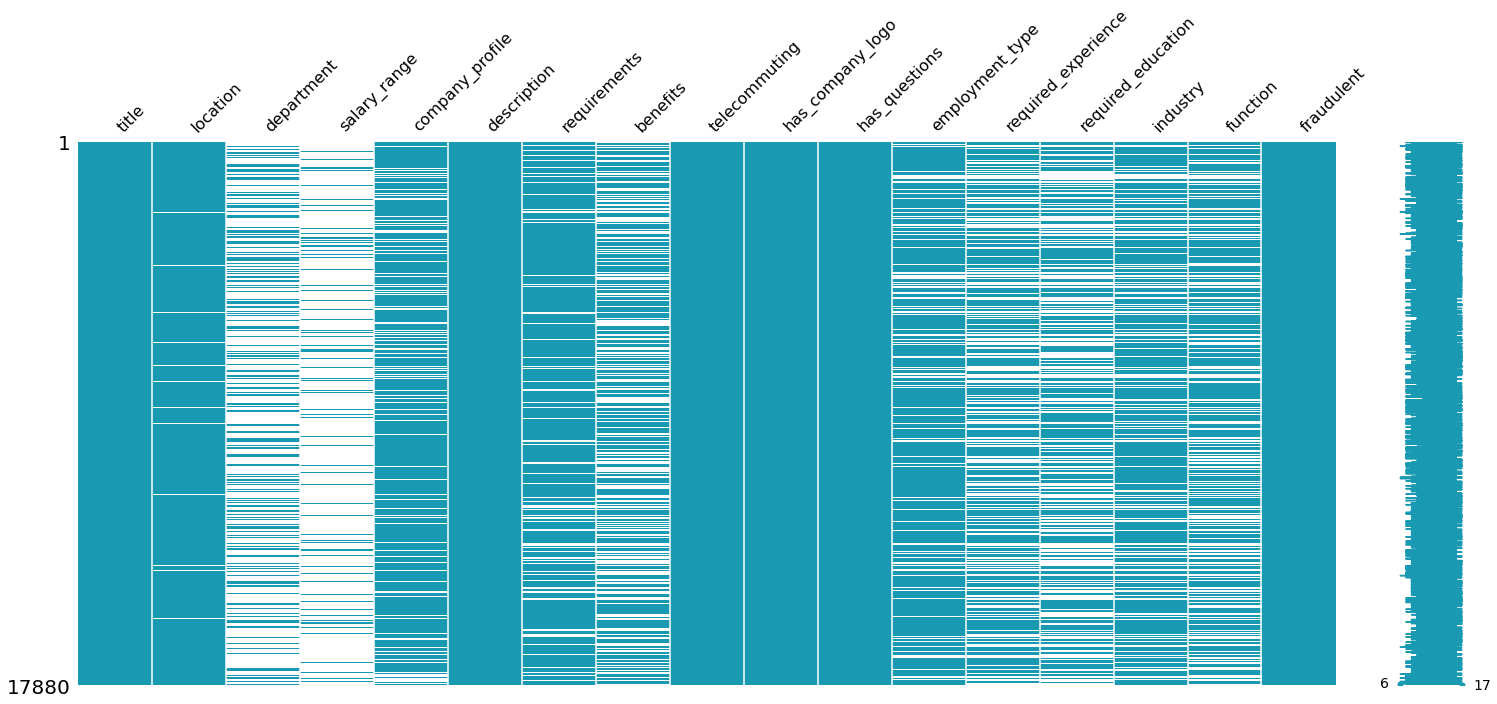

In [6]:
# checking missing data in our dataframe.
missingno.matrix(df,color=(0.1, 0.6, 0.7))

- oh wow lots of missing values

In [7]:
df.describe()

,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434
std,0.202631,0.403492,0.499945,0.214688
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


### Target
- Fraudulent

In [8]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

- First Row

In [9]:
df.description[1]

'Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff'

In [10]:
df.requirements[1]

'Experience with content management systems a major plus (any blogging counts!)Familiar with the Food52 editorial voice and aestheticLoves food, appreciates the importance of home cooking and cooking with the seasonsMeticulous editor, perfectionist, obsessive attention to detail, maddened by typos and broken links, delighted by finding and fixing themCheerful under pressureExcellent communication skillsA+ multi-tasker and juggler of responsibilities big and smallInterested in and engaged with social media like Twitter, Facebook, and PinterestLoves problem-solving and collaborating to drive Food52 forwardThinks big picture but pitches in on the nitty gritty of running a small company (dishes, shopping, administrative support)Comfortable with the realities of working for a startup: being on call on evenings and weekends, and working long hours'

In [11]:
df.benefits[1]

nan

In [12]:
df.location.value_counts()

GB, LND, London                   718
US, NY, New York                  658
US, CA, San Francisco             472
GR, I, Athens                     464
US, ,                             339
                                 ... 
GB, , Leighton Buzzard              1
GB, , Croydon                       1
GB, BIR, Birmingham / Solihull      1
US, HI, Honolulu                    1
US, MN, Burnsville                  1
Name: location, Length: 3105, dtype: int64

# Data Viz

### Fraudulent vs Not Fraudulent

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

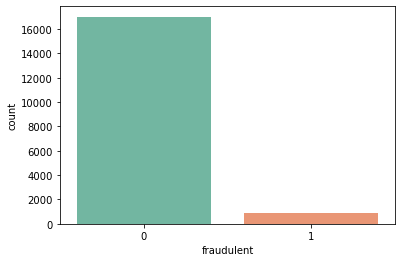

In [13]:
sns.countplot(x='fraudulent', 
              data=df,
              palette= "Set2")

### Fraudulent ads have company logo?

<AxesSubplot:xlabel='has_company_logo', ylabel='count'>

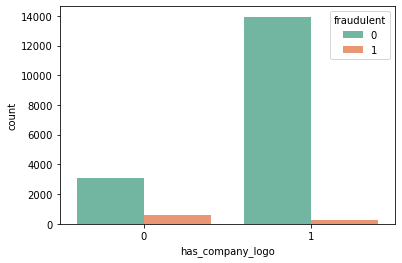

In [14]:
sns.countplot(x='has_company_logo', 
              hue='fraudulent', 
              data=df,
              palette= "Set2")

### Fraudulent ads have questions?

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

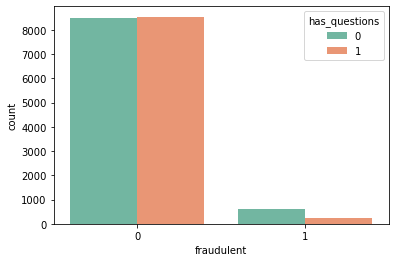

In [15]:
sns.countplot(x='fraudulent', 
              hue='has_questions', 
              data=df,
              palette= "Set2")

### Correlation between Telecommuning and fraudulent ads?

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

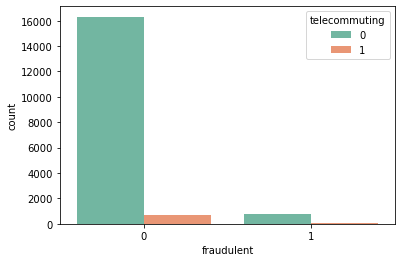

In [16]:
sns.countplot(x='fraudulent', 
              hue='telecommuting', 
              data=df,
              palette= "Set2")

### Any Department in particular that shows more fraudulence ?

In [17]:
df.department.value_counts().head(30)

Sales                     551
Engineering               487
Marketing                 401
Operations                270
IT                        225
Development               146
Product                   112
Information Technology     86
Design                     76
Technology                 76
Customer Service           73
Finance                    69
HR                         56
tech                       55
R&D                        54
Creative                   48
Retail                     45
Client Services            45
Product Development        36
Oil and Gas                32
Production                 32
Business Development       32
CSD Relay                  31
Administrative             30
Maintenance                30
Technical                  29
Tech                       29
Accounting                 29
Human Resources            29
Administration             28
Name: department, dtype: int64

### First recommendation => Do selection for department and industry

In [18]:
df.industry.value_counts().head(30)

Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Financial Services                      779
Hospital & Health Care                  497
Consumer Services                       358
Telecommunications                      342
Oil & Energy                            287
Retail                                  223
Real Estate                             175
Accounting                              159
Construction                            158
E-Learning                              139
Management Consulting                   130
Design                                  129
Staffing and Recruiting                 127
Health, Wellness and Fitness            127
Insurance                               123
Automotive                              120
Logistics and Supply Chain              112
Human Resources                 

### Fraudulent vs required_experience

In [19]:
df.required_experience.value_counts()

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

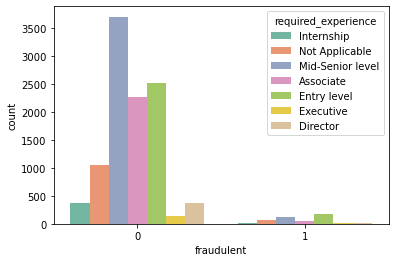

In [20]:
sns.countplot(x='fraudulent', 
              hue='required_experience', 
              data=df,
              palette= "Set2")

Well surprise surprise, looks like Entry level has something to say

### employment_type vs fraudulent

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

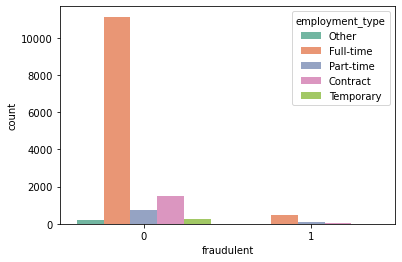

In [21]:
sns.countplot(x='fraudulent', 
              hue='employment_type', 
              data=df,
              palette= "Set2")

## Correlation

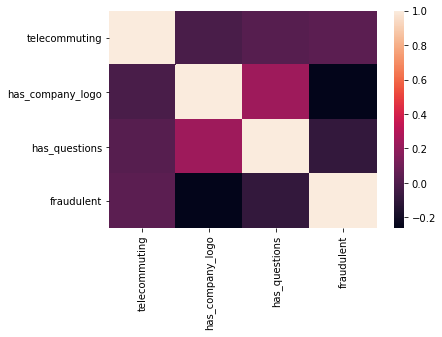

In [22]:
numeric = [col for col in df.columns if df.dtypes[col] == np.int64 or df.dtypes[col] == np.float64]
sns.heatmap(df[numeric].corr());

In [23]:
corr_abs = df.corr().abs()

compare = (corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(np.bool))
       .stack()
       .sort_values(ascending=False))
compare

has_company_logo  fraudulent          0.261971
                  has_questions       0.233932
has_questions     fraudulent          0.091627
telecommuting     fraudulent          0.034523
                  has_questions       0.020345
                  has_company_logo    0.019836
dtype: float64

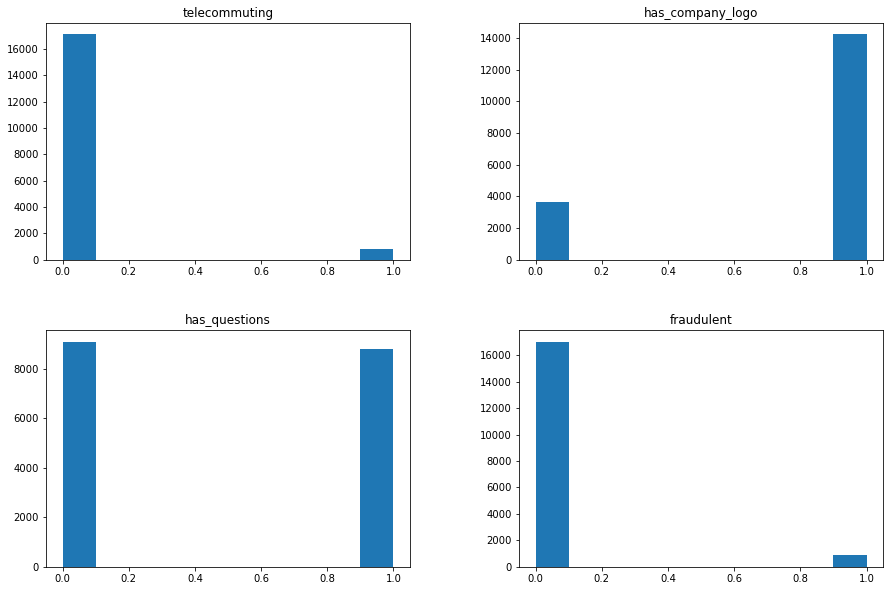

In [24]:
#for numerical
df.hist(grid= False, figsize = (15,10),);

- Check to see if null in benefits and requirements cols tell me anything

In [25]:
test = df
test['has_benefit'] = pd.notnull(test["benefits"])
test['has_requirements'] = pd.notnull(test["requirements"])
test.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements
job_id,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True


<AxesSubplot:xlabel='fraudulent', ylabel='count'>

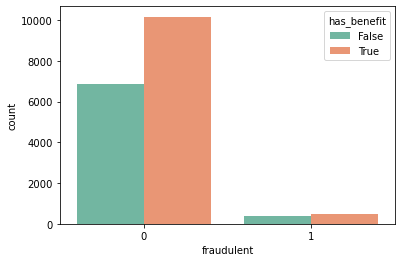

In [26]:
sns.countplot(x='fraudulent', 
              hue='has_benefit', 
              data=test,
              palette= "Set2")

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

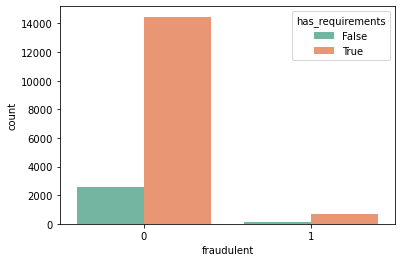

In [27]:
sns.countplot(x='fraudulent', 
              hue='has_requirements', 
              data=test,
              palette= "Set2",)

## Data Prep

In [28]:
df.location

job_id
1            US, NY, New York
2              NZ, , Auckland
3               US, IA, Wever
4          US, DC, Washington
5          US, FL, Fort Worth
                 ...         
17876         CA, ON, Toronto
17877    US, PA, Philadelphia
17878         US, TX, Houston
17879           NG, LA, Lagos
17880       NZ, N, Wellington
Name: location, Length: 17880, dtype: object

In [29]:
def split(location):
    contries = location.split(" , ")
    print(contries)
    return contries[0]


In [30]:
# df['country'] = df.location.apply(split)

- Oh well, prob not even important 

### Dealing with missing values from requirements and benefits

In [31]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'has_benefit', 'has_requirements'],
      dtype='object')

In [32]:
# Fill nulls with 'no benefit listed'
df['benefits'] = df['benefits'].fillna('no benefit listed')


In [33]:
# Fill nulls with 'no requirement listed'
df['requirements'] = df['requirements'].fillna('no requirement listed')


In [34]:
# Fill nulls with 'no description listed'
df['description'] = df['description'].fillna('no description listed')


In [35]:
df.description.isna().sum()

0

In [36]:
df.loc[17514]

title                         Office Manager
location                      PL, MZ, Warsaw
department                               NaN
salary_range                             NaN
company_profile                          NaN
description            no description listed
requirements           no requirement listed
benefits                   no benefit listed
telecommuting                              0
has_company_logo                           0
has_questions                              0
employment_type                          NaN
required_experience                      NaN
required_education                       NaN
industry                                 NaN
function                                 NaN
fraudulent                                 1
has_benefit                            False
has_requirements                       False
Name: 17514, dtype: object

 ### Combining our text data in a single column to start the cleaning  process

In [37]:
# 
df['text'] = df['description'] +'  '+ df['requirements']+'  '+ df['benefits']
df

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements,text
job_id,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,no benefit listed,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True,"Food52, a fast-growing, James Beard Award-winn..."
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,True,True,Organised - Focused - Vibrant - Awesome!Do you...
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,no benefit listed,0,1,0,NaN,NaN,NaN,NaN,NaN,0,False,True,"Our client, located in Houston, is actively se..."
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,True,True,THE COMPANY: ESRI – Environmental Systems Rese...
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,True,True,JOB TITLE: Itemization Review ManagerLOCATION:...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,True,True,Just in case this is the first time you’ve vis...
17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,True,True,The Payroll Accountant will focus primarily on...
17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,no benefit listed,0,0,0,Full-time,NaN,NaN,NaN,NaN,0,False,True,Experienced Project Cost Control Staff Enginee...


In [38]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = df[df.fraudulent==1].text
actual_jobs_text = df[df.fraudulent==0].text

In [39]:
actual_jobs_text

job_id
1        Food52, a fast-growing, James Beard Award-winn...
2        Organised - Focused - Vibrant - Awesome!Do you...
3        Our client, located in Houston, is actively se...
4        THE COMPANY: ESRI – Environmental Systems Rese...
5        JOB TITLE: Itemization Review ManagerLOCATION:...
                               ...                        
17876    Just in case this is the first time you’ve vis...
17877    The Payroll Accountant will focus primarily on...
17878    Experienced Project Cost Control Staff Enginee...
17879    Nemsia Studios is looking for an experienced v...
17880    Who are we?Vend is an award winning web based ...
Name: text, Length: 17014, dtype: object

In [40]:
actual_jobs_text.value_counts().sum()

17014

In [41]:
fraud_jobs_text.value_counts().sum()

866

In [42]:
fraud_jobs_text

job_id
99       IC&amp;E Technician | Bakersfield, CA Mt. Poso...
145      The group has raised a fund for the purchase o...
174      Technician Instrument &amp; ControlsLocation D...
181      Sales Executive  Sales Executive  Sales Executive
216      IC&amp;E Technician | Bakersfield, CA Mt. Poso...
                               ...                        
17828    Student Positions Part-Time and Full-Time.You ...
17829    LEARN TO EARN AN EXECUTIVE LEVEL INCOMEFULL TR...
17830    inFullMobile Sp. z o.o. is a mobile software d...
17831    JOB DESCRIPTIONWe are seeking a full time payr...
17832    earn $500 to $1000 a week as a mover.  Must ha...
Name: text, Length: 866, dtype: object

In [45]:
!pip install -U spacy

     |████████████████████████████████| 6.2 MB 1.5 MB/s            
     |████████████████████████████████| 42 kB 1.2 MB/s            
     |████████████████████████████████| 181 kB 1.8 MB/s            
     |████████████████████████████████| 106 kB 2.0 MB/s            
     |████████████████████████████████| 2.6 MB 1.9 MB/s            
     |████████████████████████████████| 609 kB 157 kB/s            
     |████████████████████████████████| 450 kB 1.8 MB/s            
     |████████████████████████████████| 5.8 MB 1.7 MB/s            
     |████████████████████████████████| 58 kB 2.0 MB/s            
  Attempting uninstall: smart-open
    Found existing installation: smart-open 3.0.0
    Uninstalling smart-open-3.0.0:
      Successfully uninstalled smart-open-3.0.0
You should consider upgrading via the '/Users/mellissavalle/opt/anaconda3/envs/learn-env/bin/python3.8 -m pip install --upgrade pip' command.


In [46]:
#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [57]:
!pip install -U wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Preparing metadata (setup.py) ... done
  ERROR: Command errored out with exit status 1:
   command: /Users/mellissavalle/opt/anaconda3/envs/learn-env/bin/python3.8 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/t_/ct6jlln16d1_zmk8t1pttf540000gp/T/pip-install-44c0x0k6/wordcloud_ea5b7e9ea4db42c3998f5772f071d109/setup.py'"'"'; __file__='"'"'/private/var/folders/t_/ct6jlln16d1_zmk8t1pttf540000gp/T/pip-install-44c0x0k6/wordcloud_ea5b7e9ea4db42c3998f5772f071d109/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/t_/ct6jlln16d1_zmk8t1pttf540000gp/T/pip-wheel-yed_14lw
       cwd: /private/var/folders/t_/ct6jlln16d1_zmk8t1pttf540000gp/T/pip-install-44c

Failed to build wordcloud
    Running setup.py install for wordcloud ... error
    ERROR: Command errored out with exit status 1:
     command: /Users/mellissavalle/opt/anaconda3/envs/learn-env/bin/python3.8 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/t_/ct6jlln16d1_zmk8t1pttf540000gp/T/pip-install-44c0x0k6/wordcloud_ea5b7e9ea4db42c3998f5772f071d109/setup.py'"'"'; __file__='"'"'/private/var/folders/t_/ct6jlln16d1_zmk8t1pttf540000gp/T/pip-install-44c0x0k6/wordcloud_ea5b7e9ea4db42c3998f5772f071d109/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/t_/ct6jlln16d1_zmk8t1pttf540000gp/T/pip-record-yf7ia3xb/install-record.txt --single-version-externally-managed --compile --install-headers /Us

You should consider upgrading via the '/Users/mellissavalle/opt/anaconda3/envs/learn-env/bin/python3.8 -m pip install --upgrade pip' command.


In [56]:
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'